# MPI/OpenMP analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def number_from_string(input_string):
    i = 0
    for z in input_string:
        if z.isdigit():
            break
        i = i + 1
    return input_string[i:]

def parse_file(filename):
    parsed_data = np.empty(shape=[0,3])
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            item_list = line.split()
            arr = np.array([int(number_from_string(item_list[3])), int(number_from_string(item_list[4])), float(number_from_string(item_list[6]))])
            parsed_data = np.append(parsed_data, [arr], axis=0)
    return parsed_data

data1152_mpi = parse_file("res1152_mpi")
data9216_mpi = parse_file("res9216_mpi")
data1152_omp = parse_file("res1152_omp")
data9216_omp = parse_file("res9216_omp")
data1152_mix = parse_file("res1152_mix")
data9216_mix = parse_file("res9216_mix")

In [3]:
tau = 30.0
Lc = lambda p,N: (1.0*N)/p*(p-1)
La = lambda p,N: (1.0*N*N)/p
L = lambda p,N: Lc(p,N)/La(p,N)
theoretical_speedup = lambda p,N: (1.0*p)/(1.0 + tau*L(p, N))
linear_speedup = lambda p: p
speedup = lambda times: np.divide(np.ones(times.size)*times[0], times)

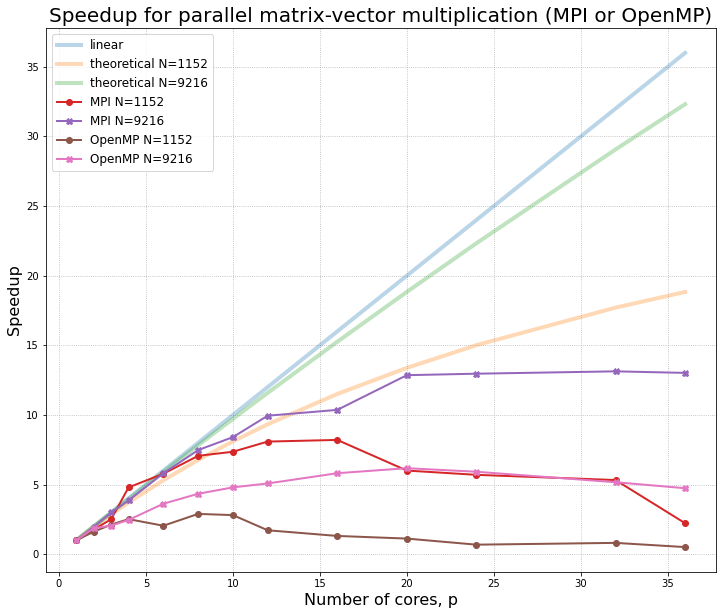

In [4]:
plt.rcParams["figure.figsize"] = [12.0, 10.0]
plt.plot([data[0] for data in data1152_mpi], [linear_speedup(data[0]) for data in data1152_mpi], alpha=0.3, label = 'linear', linewidth = 4)
plt.plot([data[0] for data in data1152_mpi], [theoretical_speedup(data[0], 1152) for data in data1152_mpi], alpha = 0.3, label = 'theoretical N=1152', linewidth = 4)
plt.plot([data[0] for data in data9216_mpi], [theoretical_speedup(data[0], 9216) for data in data9216_mpi], alpha = 0.3, label = 'theoretical N=9216', linewidth = 4)
plt.plot([data[0] for data in data1152_mpi], speedup(np.array([data[2] for data in data1152_mpi])), label='MPI N=1152', marker = 'o', linewidth = 2)
plt.plot([data[0] for data in data9216_mpi], speedup(np.array([data[2] for data in data9216_mpi])), label='MPI N=9216', marker = 'X', linewidth = 2)
plt.plot([data[1] for data in data1152_omp], speedup(np.array([data[2] for data in data1152_omp])), label='OpenMP N=1152', marker = 'o', linewidth = 2)
plt.plot([data[1] for data in data9216_omp], speedup(np.array([data[2] for data in data9216_omp])), label='OpenMP N=9216', marker = 'X', linewidth = 2)
plt.title("Speedup for parallel matrix-vector multiplication (MPI or OpenMP)", fontsize=20)
plt.xlabel("Number of cores, p", fontsize=16)
plt.ylabel("Speedup", fontsize=16)
plt.legend(loc='upper left', fontsize=12)
plt.grid(linestyle='dotted')
plt.show()

# Hybrid MPI+OpenMP analysis

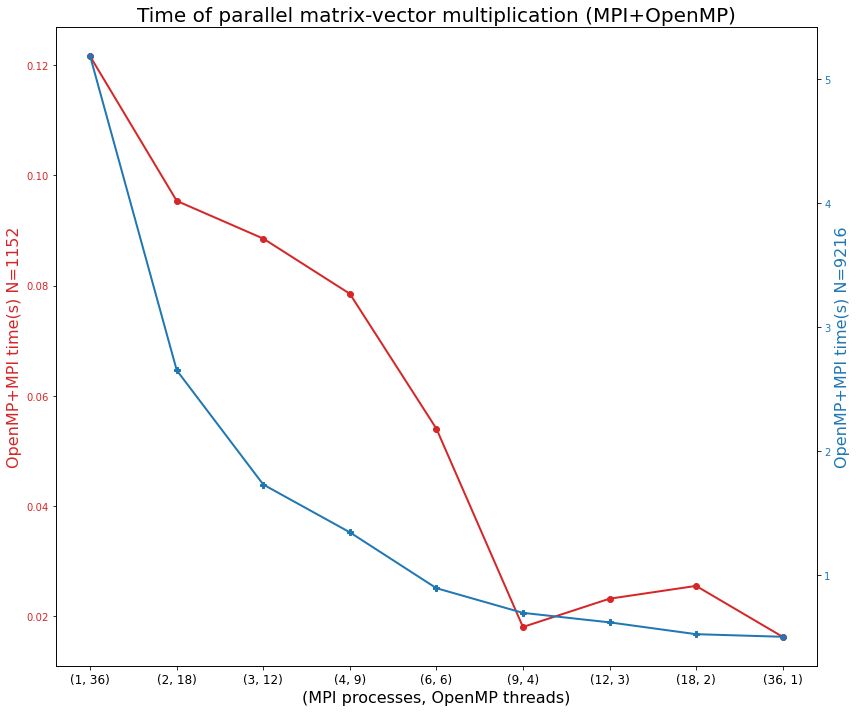

In [5]:
plt.rcParams["figure.figsize"] = [12.0, 10.0]
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('(MPI processes, OpenMP threads)', fontsize=16)
ax1.set_xticks(np.arange(0, 9))
ax1.set_xticklabels(["(1, 36)", "(2, 18)", "(3, 12)", "(4, 9)", "(6, 6)", "(9, 4)", "(12, 3)", "(18, 2)", "(36, 1)"], fontsize=12)
ax1.set_ylabel('OpenMP+MPI time(s) N=1152', color=color, fontsize=16)
ax1.plot([data1152_mix[i][2] for i in np.arange(0, 9)], color=color, linewidth=2, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('OpenMP+MPI time(s) N=9216', color=color, fontsize=16) 
ax2.plot([data9216_mpi[i][2] for i in np.arange(0, 9)], color=color, linewidth=2, marker='P')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Time of parallel matrix-vector multiplication (MPI+OpenMP)", fontsize=20)

fig.tight_layout()
plt.show()

# Conclusion

* Реализован параллельный алгоритм умножения плотной матрицы на вектор;
* Продемонстрировано ускорение работы параллельной программы с помощью MPI, OpenMP и гибридной архитектуры MPI+OpenMP;
* Распараллеливание с помощью MPI показало лучшую эффективность, по сравнению с OpenMP, т.к. кривая ускорения находится ближе к теоретическому значению;
* При увеличении числа процессоров/нитей эффективность параллельной программы уменьшается из-за затрат на обмены в случае MPI (время обменов начинает играть значительную роль по сравнению с времен вычислений на отдельном процессоре) и затрат на создание/синхронизацию OpenMP-нитей (эти затраты становятся сравнимы со временем вычисления отдельной нити);
* Причиной отличия практического ускорения от теоретического может заключаться в загруженности вычислительного кластера и непостоянности параметра tau (характеристика параллельного компьютера) во времен;
* Видно, что в случае небольшого числа процессоров наблюдается сверхлинейное ускорение, что может быть связанно с попаданием части матрицы в кэш процессора, засчет чего значительно ускоряется процесс аоифметических вычислений;
* В силу того, что MPI-параллелелизм доминирует над OpenMP для данной реализации в случае большого размера матрицы, наиболее эффективным является использование 36 процессоров без дополнительных OpenMP-нитей. В случае небольшого размера матрицы оптимальным оказывается использование 9 процессоров и 6 нитей.